<img src='../__docs/__all/notebook_rules.png' />

# Python Import 

In [1]:
debugging = True

import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import glob
# from NeuNorm.normalization import Normalization
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib notebook

from plotly.offline import plot, init_notebook_mode, iplot
import plotly.express as px
import plotly.graph_objects as go

# from __code.file_folder_browser import FileFolderBrowser

from __code import system
system.System.select_working_dir()

from code.ipts_28402 import IPTS_28402


** Using Debugging Mode! **


# Select Images 

In [2]:
o_ipts = IPTS_28402(working_dir=system.System.get_working_dir(), debugging=debugging)
o_ipts.select_images()

# Visualize Raw Data

The data are rotated 90 degrees to work with the cylindrical geometry algorithm

<IPython.core.display.Javascript object>


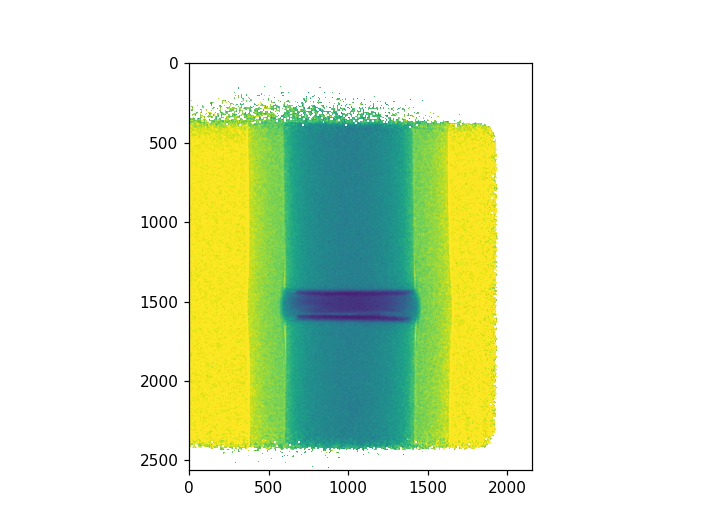

interactive(children=(IntSlider(value=0, description='image_index', layout=Layout(width='50%'), max=5), Output…

In [3]:
o_ipts.visualize_raw_images()

# crop sample to region of interest 

By playing with the **left**, **right**, **top** and **bottom** sliders, select a region surrounding the data you
want to correct.
<html>
    <br>
    <font color="red">Warning:</color>
    </html>
Make sure you include the external cylinder (container) in the selection.

<IPython.core.display.Javascript object>


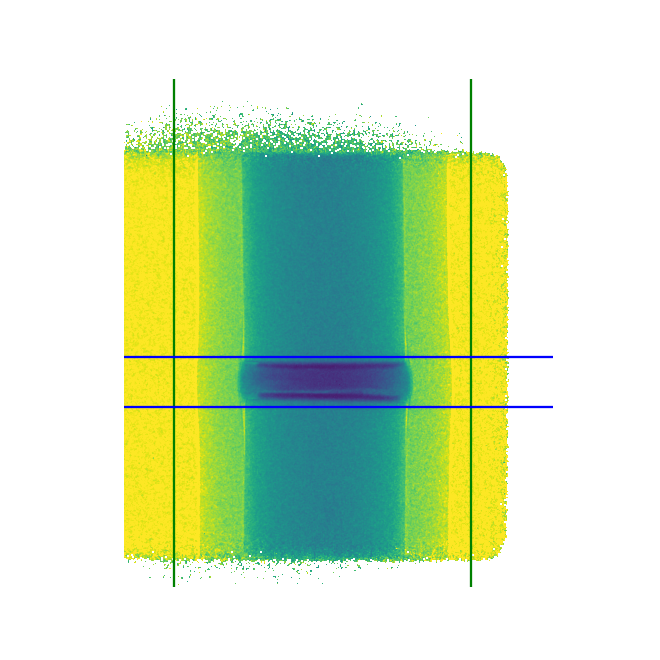

interactive(children=(IntSlider(value=0, description='image_index', max=5), IntSlider(value=251, description='…

In [4]:
o_ipts.select_crop_region()

## Visualize result of cropping 

In [5]:
o_ipts.visualize_crop()

<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

# Selection of the profiles to correct

Select the **top limit** and **bottom limit** profiles to correct. The program will then correct all the horizontal profiles between those 2 limits

In [6]:
o_ipts.selection_of_profiles_limit()

interactive(children=(IntSlider(value=0, description='image_index', max=5), IntSlider(value=0, description='to…

In [48]:
left = 0 
right = 2000
top = 1400
bottom = 1650

In [49]:
rotated_cropped_data = [_data[top:bottom, left:right] for _data in rotated_data]

<IPython.core.display.Javascript object>


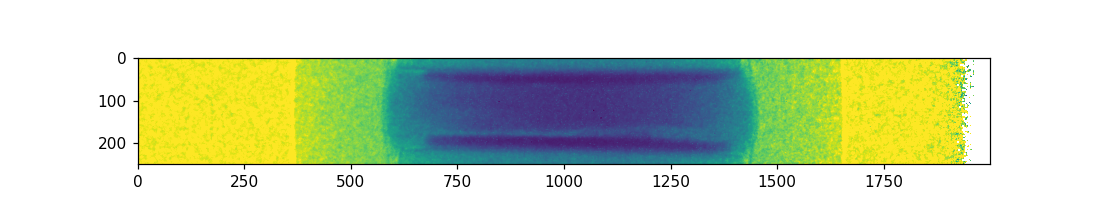

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [50]:
plt.figure(3, figsize=(10,2))

def plot(image_index):
    data = rotated_cropped_data[image_index]
    ax = plt.imshow(data, vmin=0, vmax=1)

v = interactive(plot, 
               image_index = widgets.IntSlider(min=0, max=len(list_images)-1, value=0))
display(v)
    

# Profile position 

In [51]:
profile_y = 125

<IPython.core.display.Javascript object>


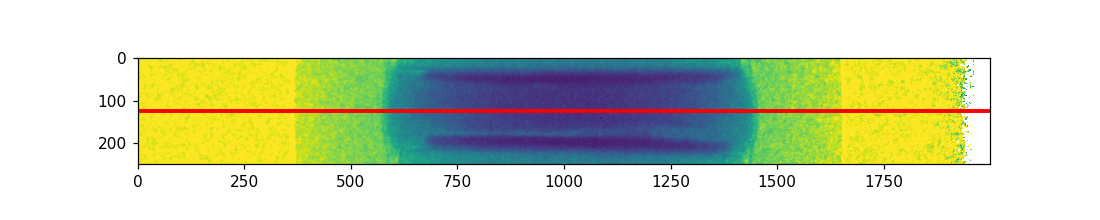

interactive(children=(IntSlider(value=0, description='image_index', max=5), Output()), _dom_classes=('widget-i…

In [73]:
plt.figure(4, figsize=(10,2))

def plot(image_index):
    data = rotated_cropped_data[image_index]
    ax = plt.imshow(data, vmin=0, vmax=1)
    plt.axhline(y=profile_y, color='red')

v = interactive(plot, 
               image_index = widgets.IntSlider(min=0, max=len(list_images)-1, value=0))
display(v)
    

# Focusing on a given image index 

In [53]:
image_index = 0 

In [54]:
slice_of_this_image = rotated_cropped_data[image_index][profile_y, :]

<IPython.core.display.Javascript object>


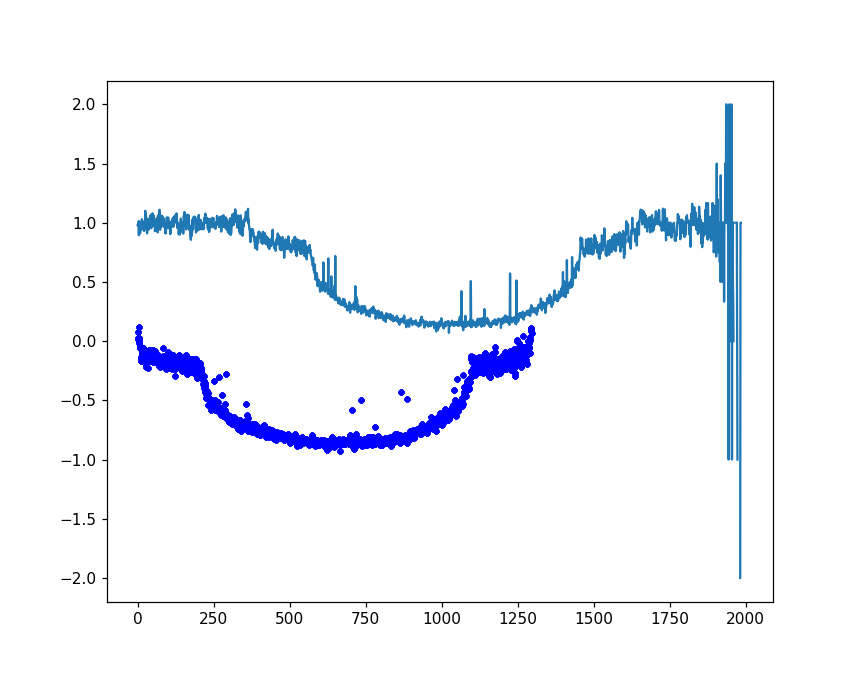

In [55]:
fig = plt.subplots(ncols=1, nrows=1, figsize=(5,5), num="Profile")
plt.plot(slice_of_this_image)

# Defining the cylinders edges 

In [56]:
default_left_outer = 362
default_right_outer = 1652
default_left_inner = 559
default_right_inner = 1459

<IPython.core.display.Javascript object>


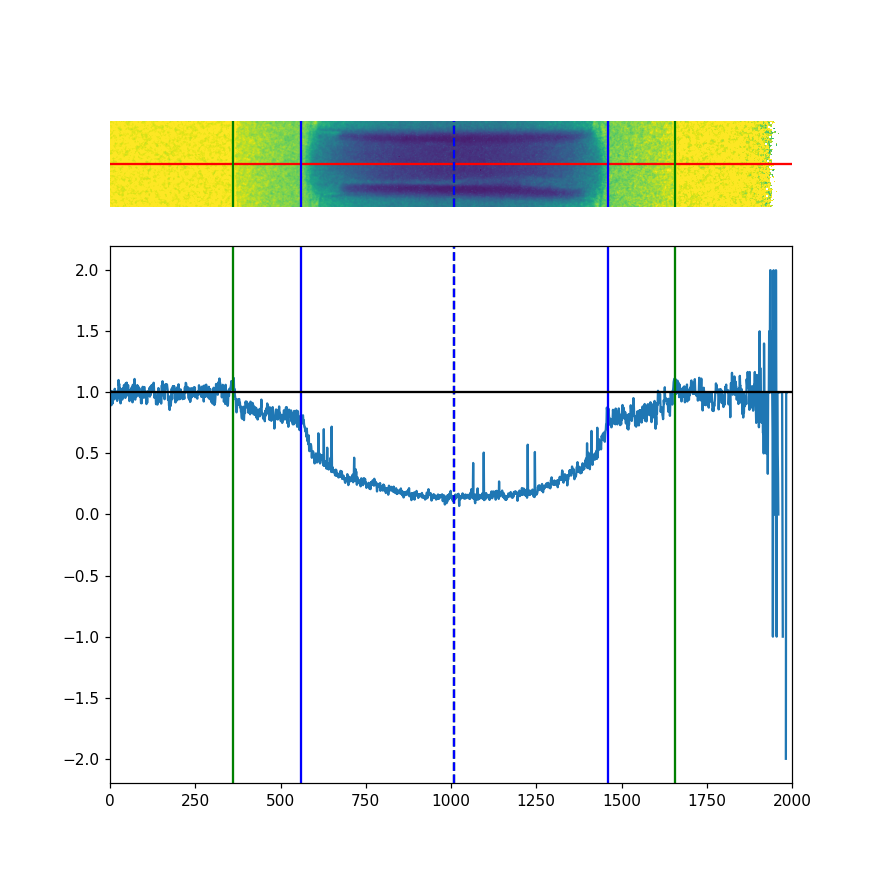

interactive(children=(IntSlider(value=362, description='left_outer', max=2000), IntSlider(value=1652, descript…

In [82]:
#fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(10,6), num="Cylinders Edges")

fig = plt.figure(6)
fig.set_figheight(8)
fig.set_figwidth(8)

def plot(left_outer, right_outer, left_inner, right_inner):
    ax1 = plt.subplot2grid(shape=(5,1), loc=(0,0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid(shape=(5,1), loc=(1,0), colspan=1, rowspan=4)
    ax1.axhline(y=profile_y, color='red')

    outer_center = np.mean([left_outer, right_outer])
    inner_center = np.mean([left_inner, right_inner])
    
    data = rotated_cropped_data[image_index]
    ax1.imshow(data, vmin=0, vmax=1)
    ax1.axis('off')
    ax1.axvline(x=left_outer, color='green')
    ax1.axvline(x=right_outer, color='green')   
    ax1.axvline(x=outer_center, color='green', linestyle='--')
    ax1.axvline(x=left_inner, color='blue')
    ax1.axvline(x=right_inner, color='blue')
    ax1.axvline(x=inner_center, color='blue', linestyle='--')
    
    ax2.plot(slice_of_this_image)
    ax2.set_xlim([0, 2000])
    ax2.axvline(x=left_outer, color='green')
    ax2.axvline(x=right_outer, color='green')
    ax2.axvline(x=outer_center, color='green', linestyle='--')
    ax2.axvline(x=left_inner, color='blue')
    ax2.axvline(x=right_inner, color='blue')
    ax2.axvline(x=inner_center, color='blue', linestyle='--')
    
    # for reference, plotting the y-axis 1
    ax2.axhline(y=1, color="black")
    
    return left_outer, right_outer, left_inner, right_inner
    
v = interactive(plot, 
               left_outer = widgets.IntSlider(min=0, 
                                              max=np.floor(len(slice_of_this_image)), 
                                              value=default_left_outer),
               right_outer = widgets.IntSlider(min=0, 
                                               max=np.floor(len(slice_of_this_image)), 
                                               value=default_right_outer),
               left_inner = widgets.IntSlider(min=0, 
                                              max=np.floor(len(slice_of_this_image)), 
                                              value=default_left_inner),
               right_inner = widgets.IntSlider(min=0, 
                                               max=np.floor(len(slice_of_this_image)), 
                                               value=default_right_inner),
               )
display(v)

# Removing edges 

This only keeps the data of interest

In [135]:
[left_outer, right_outer, left_inner, right_inner] = v.result
profile_data = slice_of_this_image[left_outer: right_outer+1]

<IPython.core.display.Javascript object>


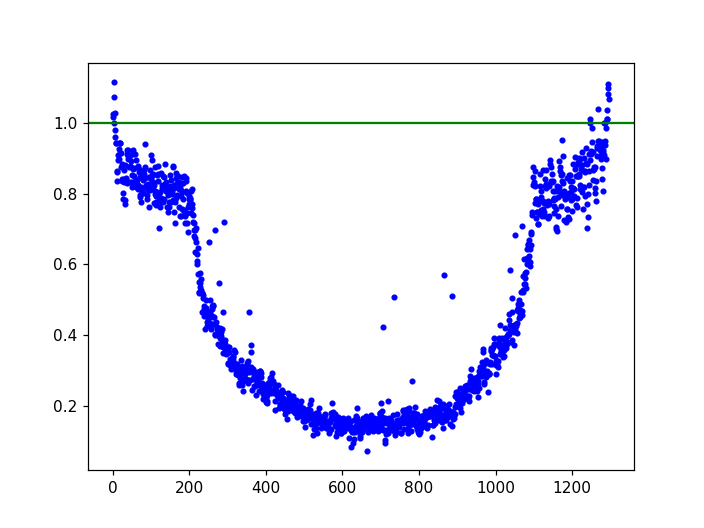

interactive(children=(FloatSlider(value=1.0, description='Threshold', layout=Layout(width='50%'), max=1.0, ste…

In [94]:
fig = plt.figure(8)

def plot_threshold(threshold_value):
    
    ax = plt.subplot()
    plt.cla()
    plt.plot(profile_data, '.b')
    plt.axhline(y=threshold_value, color='green')
    return threshold_value

plot_thresold_ref = interactive(plot_threshold, 
                    threshold_value = widgets.FloatSlider(min=0, 
                                                          description='Threshold',
                                                          max=1,
                                                          value=1,
                                                          step=0.01,
                                                          layout=widgets.Layout(width='50%')))
display(plot_thresold_ref)

# Calculating the base threshold of the outer cylinder

We need to reverse the data and have base of outer cylinder being at 0 

In [95]:
threshold_value_to_use = plot_thresold_ref.result

<IPython.core.display.Javascript object>


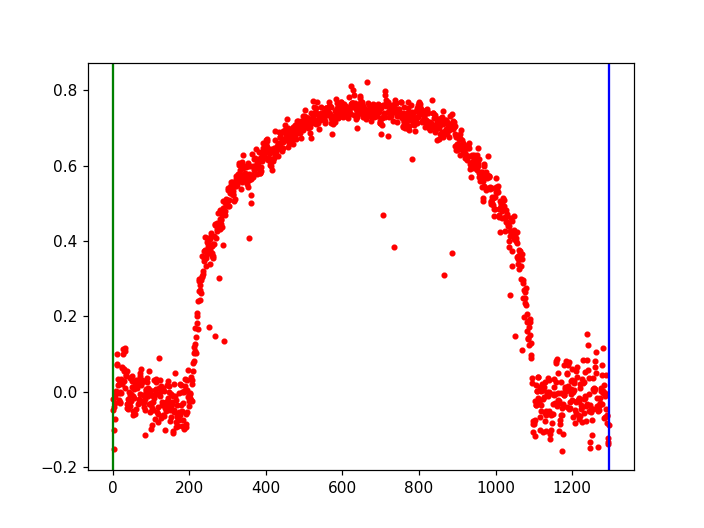

In [134]:
profile_data_reversed = threshold_value_to_use - profile_data

plt.figure(10)
plt.plot(profile_data_reversed, '.b')

# Applying the Geometry correction 

In [137]:
pixel_center = int(np.mean([left_outer, right_outer]))
outer_radius = int((right_outer+1 - left_outer)/2)
inner_radius = int((right_inner+1 - left_inner)/2)

## Step1, we need to evaluate the intensity (constant) of the walls 

In [138]:
def number_of_pixel_at_that_position2(position=-1, inner_circle_r=1, outer_circle_r=1):
#    new_position = np.abs(outer_circle_r - position)
    new_position = np.abs(position)

    if new_position < inner_circle_r:
        rp1 = 2*inner_circle_r*np.sin(np.arccos(new_position/inner_circle_r))
        rp2 = 2*outer_circle_r*np.sin(np.arccos(new_position/outer_circle_r))
        rp = rp2 - rp1
        return rp
    elif (new_position >= inner_circle_r) and (new_position < outer_circle_r):
        return 2*outer_circle_r*np.sin(np.arccos(new_position/outer_circle_r))
    elif new_position == outer_circle_r:
        return 1
    else:
        return 0
    
def number_of_pixels_at_that_position1(position=0, radius=1):  
    new_position = np.abs(radius - position)
    half_number_of_pixels = radius*np.sin(np.arccos(new_position/radius))
    if new_position == radius:
        return 1

    number_of_pixels = half_number_of_pixels * 2
    return number_of_pixels

In [139]:
d = np.arange(0, 2*outer_radius)
intensity = profile_data_reversed

x = 100
measure = profile_data_reversed[100]
number_of_pixels_through_thickness = number_of_pixels_at_that_position1(position=x, radius=outer_radius)
intensity_of_ring = measure / number_of_pixels_through_thickness

print(f"intensity of ring is: {intensity_of_ring}")

intensity of ring is: 0.00021944988719808657


In [140]:
intensity_of_ring_array = []
for x in np.arange(0, 100):
    measure = profile_data_reversed[x]
    number_of_pixels_through_thickness = number_of_pixels_at_that_position1(position=x, radius=outer_radius)
    intensity_of_ring_array.append(measure / number_of_pixels_through_thickness)
    
intensity_of_ring = np.median(intensity_of_ring_array)

<IPython.core.display.Javascript object>


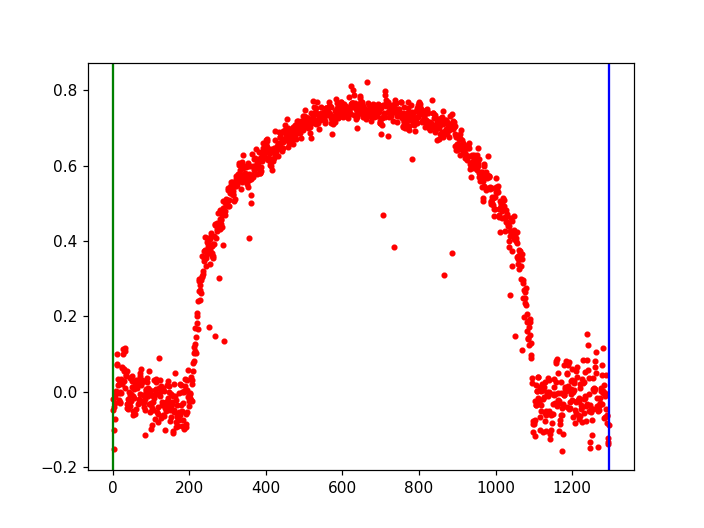

In [141]:
plt.subplots(num='Attenuation per pixel of outer ring')
plt.plot(intensity_of_ring_array, '.b')

In [154]:
shape_of_ring_signal = []
for x in np.arange(0, outer_radius+1):
    nbr_pixels = number_of_pixel_at_that_position2(position=x, 
                                                   inner_circle_r=inner_radius,
                                                   outer_circle_r=outer_radius)

    shape_of_ring_signal.append(nbr_pixels * intensity_of_ring)
    
full_shape_of_ring_signal = np.concatenate((shape_of_ring_signal[::-1], shape_of_ring_signal[:-1:]))

trace = go.Scatter(y=full_shape_of_ring_signal)
layout = go.Layout(title="Shape of ring",
                  xaxis=dict(title=""),
                  yaxis=dict(title=""))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)

In [167]:
removed_ring_counts = profile_data_reversed - full_shape_of_ring_signal

trace = go.Scatter(y=removed_ring_counts,
                  mode='markers',
                  marker=dict(color='Blue',
                             line=dict(color='Red',
                                      width=1)))
layout = go.Layout(title="shape of ring with outside cylinder corrected",
                   xaxis=dict(title=""),
                   yaxis=dict(title=""))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)

# Inner cylinder 

We find the center, radius and truncate outside cylinder, keeping only the data from the inner cylinder

In [171]:
center = int(len(removed_ring_counts)/2)
radius = inner_radius

print(f"Center position: {center}")
print(f"radius: {radius}")

Center position: 648
radius: 450


<IPython.core.display.Javascript object>


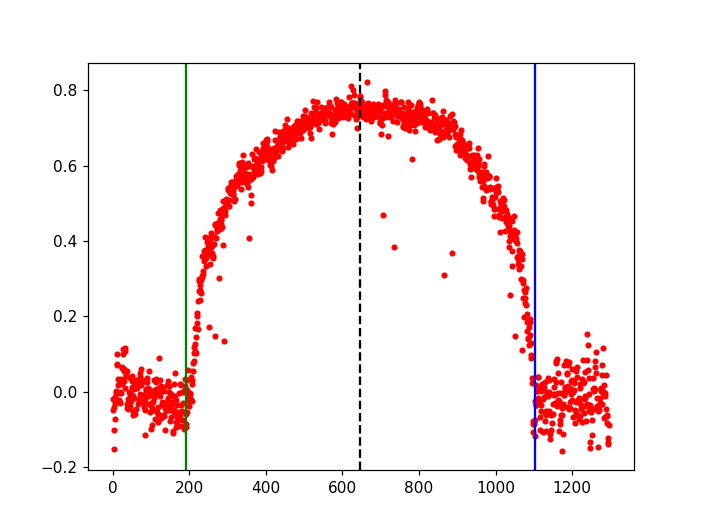

interactive(children=(IntSlider(value=0, description='left_edge', max=1296), IntSlider(value=1296, description…

In [188]:
fig = plt.figure(15)

def find_edges(left_edge, right_edge):  
    ax = plt.subplot()

    plt.cla()
    plt.plot(removed_ring_counts, '.r')
    plt.axvline(x=left_edge, color='green')
    plt.axvline(x=right_edge, color='blue')

    #center
    center = int(np.mean([right_edge, left_edge]))
    plt.axvline(x=center, color='black', linestyle='--')
                 
    
    return left_edge, right_edge

find_edges_ui = interactive(find_edges, 
                    left_edge = widgets.IntSlider(min=0, 
                                                  max=len(removed_ring_counts)-1,
                                                  value=0,
                                                  step=1),
                   right_edge = widgets.IntSlider(min=0, 
                                                  max=len(removed_ring_counts)-1,
                                                  value=len(removed_ring_counts)-1,
                                                  step=1))

display(find_edges_ui)

In [193]:
[left_edge, right_edge] = find_edges_ui.result

print(f"left edge: {left_edge}")
print(f"right edge: {right_edge}")

left edge: 192
right edge: 1102


In [197]:
inner_cylinder_data = removed_ring_counts[left_edge: right_edge+1]
radius = int(len(inner_cylinder_data) / 2)

<IPython.core.display.Javascript object>


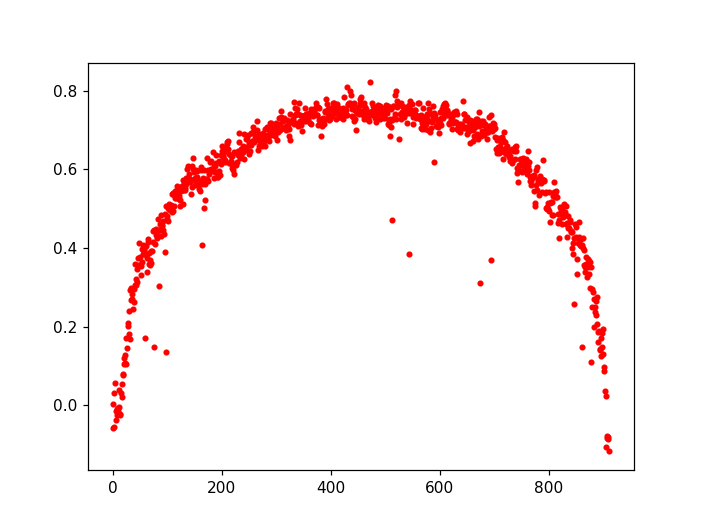

In [196]:
fig = plt.figure(16)
ax = plt.subplot()
plt.plot(inner_cylinder_data, '.r')


In [208]:
d = np.arange(0, 2*radius)
intensity = inner_cylinder_data

expected_array = []
number_of_pixels = []
for _index, x in enumerate(d):
    measure = intensity[_index]
    number_of_pixels_through_thickness = number_of_pixels_at_that_position1(position=x, 
                                                                            radius=radius)
    number_of_pixels.append(number_of_pixels_through_thickness)
    expected_array.append(measure / number_of_pixels_through_thickness)

trace = go.Scatter(y=expected_array, mode='markers')
layout = go.Layout(title="Expected Array",
                  xaxis=dict(title="pixel"),
                  yaxis=dict(title="Counts per pixel",
                             range=[0,.0015],
                            ))

figure = go.Figure(data=[trace], layout=layout)
iplot(figure)